In [10]:
# LOAD PACKAGES
import warnings
import torch
from gpytorch.distributions import base_distributions
from gpytorch.functions import log_normal_cdf
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import gpytorch
import time as time

In [11]:
# implement BinomialLikelihood
class BinomialLikelihood(_OneDimensionalLikelihood):
    r"""
    Implements the Binomial likelihood for count data y between 1 and m. 
    The Binomial distribution is parameterized by :math:`m > 0`. 
    We can write the likelihood as:

    .. math::
        \begin{equation*}
            p(Y=y|f,m)=\phi(f)^y(1-\phi(f))^{(m-y)}
        \end{equation*}
    """

    def __init__(self, n_trials):
        super().__init__()
        self.n_trials = n_trials

    def forward(self, function_samples, **kwargs):
        output_probs = base_distributions.Normal(0, 1).cdf(function_samples)
        return base_distributions.Binomial(total_count=self.n_trials, probs=output_probs)

    def log_marginal(self, observations, function_dist, *args, **kwargs):
        marginal = self.marginal(function_dist, *args, **kwargs)
        return marginal.log_prob(observations)

    def marginal(self, function_dist, **kwargs):
        mean = function_dist.mean
        var = function_dist.variance
        link = mean.div(torch.sqrt(1 + var))
        output_probs = base_distributions.Normal(0, 1).cdf(link)
        return base_distributions.Binomial(total_count=self.num_data, probs=output_probs)

    def expected_log_prob(self, observations, function_dist, *params, **kwargs):
        if torch.any(torch.logical_or(observations.le(-1), observations.ge(self.n_trials+1))):
            # Remove after 1.0
            warnings.warn(
                "BinomialLikelihood.expected_log_prob expects observations with labels in [0, m]. "
                "Observations <0 or >m are not allowed.",
                DeprecationWarning,
            )
        else:
            for i in range(observations.size(0)):
                observations[i] = torch.clamp(observations[i],0,self.n_trials[i])

        # Custom function here so we can use log_normal_cdf rather than Normal.cdf
        # This is going to be less prone to overflow errors
        log_prob_lambda = lambda function_samples: self.n_trials*log_normal_cdf(-function_samples) + \
                observations.mul(log_normal_cdf(function_samples)-log_normal_cdf(-function_samples))
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob

In [12]:
# implement GP class
class BinomialGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(BinomialGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.LinearMean(input_size=train_x.size(1))
        # ARD kernel for covariate, geospatial and time confounding
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.size(1)))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
def transform_data(data):
    n = data.shape[0]
    x = np.zeros((n,11))
    y = np.zeros((n,))
    theta = np.zeros((n,))
    N = np.zeros((n,))
    x[:,0] = data["lat"].to_numpy()
    x[:,1] = data["lon"].to_numpy()
    x[:,2] = (data["gender"].to_numpy()=="Male")
    x[:,3] = (data["gender"].to_numpy()=="Female")
    x[:,4] = (data["gender"].to_numpy()=="Non-binary")
    x[:,5] = (data["race"].to_numpy()=="White")
    x[:,6] = (data["race"].to_numpy()=="Black")
    x[:,7] = (data["race"].to_numpy()=="Other")
    x[:,8] = data["year"].to_numpy()
    latent_pref = data["latent_group_pref"].to_numpy()
    y = data["Y"].to_numpy()
    N = data["n"].to_numpy()

    return (
        torch.from_numpy(x).double(),
        torch.from_numpy(y).double(),
        torch.from_numpy(N).double(),
        torch.from_numpy(latent_pref).double()
    )


In [32]:
torch.manual_seed(0)

def standardize_features(df, columns):
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        df[col] = (df[col] - mean_val) / (std_val + 1e-8)
    return df

# load data
train_data = pd.read_csv("/home/j.yeeun/GP_models/Datasets/sample_agg_train.csv", index_col=0)
test_data = pd.read_csv("/home/j.yeeun/GP_models/Datasets/sample_agg_test.csv", index_col=0)

# standardize lat, lon, and year 
cols_to_scale = ["lat", "lon", "year"]
train_data = standardize_features(train_data, cols_to_scale)
test_data = standardize_features(test_data, cols_to_scale)

# transform data
train_x, train_y, train_N, train_pref = transform_data(train_data)
test_x, test_y, test_N, test_pref = transform_data(test_data)

# initialize likelihood and model
likelihood = BinomialLikelihood(n_trials=train_N)
model = BinomialGPModel(train_x=train_x).double()

training_iterations = 200

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) 

mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

start = time.time()

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

end = time.time()

Iter 1/200 - Loss: 85.972
Iter 2/200 - Loss: 328.941
Iter 3/200 - Loss: 103.771
Iter 4/200 - Loss: 131.637
Iter 5/200 - Loss: 157.423
Iter 6/200 - Loss: 121.187
Iter 7/200 - Loss: 78.763
Iter 8/200 - Loss: 58.273
Iter 9/200 - Loss: 55.338
Iter 10/200 - Loss: 56.306
Iter 11/200 - Loss: 53.847
Iter 12/200 - Loss: 48.350
Iter 13/200 - Loss: 42.638
Iter 14/200 - Loss: 38.294
Iter 15/200 - Loss: 35.248
Iter 16/200 - Loss: 32.941
Iter 17/200 - Loss: 31.075
Iter 18/200 - Loss: 29.512
Iter 19/200 - Loss: 28.083
Iter 20/200 - Loss: 26.708
Iter 21/200 - Loss: 25.463
Iter 22/200 - Loss: 24.441
Iter 23/200 - Loss: 23.599
Iter 24/200 - Loss: 22.805
Iter 25/200 - Loss: 21.997
Iter 26/200 - Loss: 21.240
Iter 27/200 - Loss: 20.616
Iter 28/200 - Loss: 20.132
Iter 29/200 - Loss: 19.714
Iter 30/200 - Loss: 19.297
Iter 31/200 - Loss: 18.868
Iter 32/200 - Loss: 18.468
Iter 33/200 - Loss: 18.133
Iter 34/200 - Loss: 17.862
Iter 35/200 - Loss: 17.626
Iter 36/200 - Loss: 17.401
Iter 37/200 - Loss: 17.176
Iter 

In [33]:
print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale)

tensor([[0.9913, 0.8899, 0.4632, 0.4632, 0.6931, 0.4319, 0.4207, 0.4712, 0.4330,
         0.6931, 0.6931]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
tensor(0.4002, dtype=torch.float64, grad_fn=<SoftplusBackward0>)


In [34]:
print("trained for {:d} min {:d} sec for {:d} iterations".format(int(end-start)//60,int(end-start)%60,training_iterations))

trained for 18 min 44 sec for 200 iterations


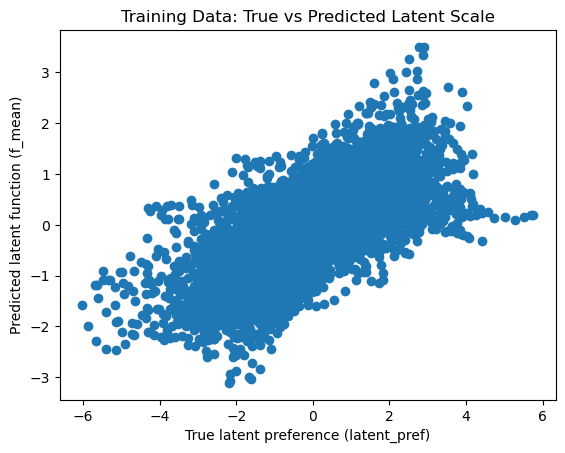

In [35]:
model.eval()
likelihood.eval()

with torch.no_grad():
    f_pred = model(train_x)
    # mean of the latent function f(x)
    mu = f_pred.mean.numpy()

plt.scatter(train_pref.numpy(), mu)  
plt.xlabel("True latent preference (latent_pref)")
plt.ylabel("Predicted latent function (f_mean)")
plt.title("Training Data: True vs Predicted Latent Scale")
plt.show()

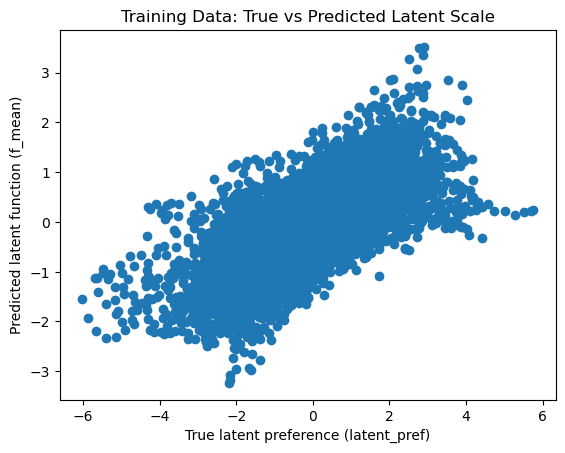

In [36]:
model.eval()
likelihood.eval()

with torch.no_grad():
    f_pred2 = model(test_x)
    mu2 = f_pred2.mean.numpy()

plt.scatter(test_pref.numpy(), mu2)  
plt.xlabel("True latent preference (latent_pref)")
plt.ylabel("Predicted latent function (f_mean)")
plt.title("Training Data: True vs Predicted Latent Scale")
plt.show()

In [37]:
results = pd.DataFrame({
    "true_pref": train_pref.numpy(), 
    "est_mean": mu  
})

results["est_std"] = np.sqrt(f_pred.variance.numpy())  

lower = results['est_mean'] - 2*results['est_std']
upper = results['est_mean'] + 2*results['est_std']

coverage = np.mean(np.logical_and(lower <= results["true_pref"], upper >= results["true_pref"]))
rmse = np.sqrt(np.mean((results["true_pref"] - results["est_mean"]) ** 2))
correlation = np.corrcoef(results["true_pref"], results["est_mean"])[0, 1]

print("Train avg 95% Coverage: {:.3f}".format(coverage))
print("Train avg RMSE: {:.3f}".format(rmse))
print("Train correlation: {:.3f}".format(correlation))

Train avg 95% Coverage: 0.204
Train avg RMSE: 1.158
Train correlation: 0.703


In [38]:
results2 = pd.DataFrame({
    "true_pref": test_pref.numpy(), 
    "est_mean": mu2  
})

results2["est_std"] = np.sqrt(f_pred2.variance.numpy())  

lower = results2['est_mean'] - 2*results2['est_std']
upper = results2['est_mean'] + 2*results2['est_std']

coverage = np.mean(np.logical_and(lower <= results2["true_pref"], upper >= results2["true_pref"]))
rmse = np.sqrt(np.mean((results2["true_pref"] - results2["est_mean"]) ** 2))
correlation = np.corrcoef(results2["true_pref"], results2["est_mean"])[0, 1]

print("Train avg 95% Coverage: {:.3f}".format(coverage))
print("Train avg RMSE: {:.3f}".format(rmse))
print("Train correlation: {:.3f}".format(correlation))

Train avg 95% Coverage: 0.208
Train avg RMSE: 1.144
Train correlation: 0.714
